In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA 
from sklearn.svm import LinearSVC
from sklearn import linear_model

In [64]:
df = pd.read_csv('fullsetmatrix1.csv', index_col='Time')
df.index = pd.to_datetime(df.index)
print(df.head())
n_row, n_col = df.shape
print(f'There are {n_row} rows and {n_col} columns')


                     Unnamed: 0     bch      btc     eth    ltc      xpr
Time                                                                    
2018-08-15 18:45:00           0     NaN      NaN  297.56    NaN      NaN
2018-08-15 18:46:00           1     NaN  6547.42  297.81    NaN  0.29083
2018-08-15 18:47:00           2     NaN  6549.43  297.82    NaN  0.29084
2018-08-15 18:48:00           3     NaN  6547.86  298.37    NaN  0.29010
2018-08-15 18:49:00           4  529.41  6534.95  297.94  58.07  0.29084
There are 54053 rows and 6 columns


As we've already Identified previously, we have to deal with missing values (NaN) within our dataset. In our correlation analysis, we had backfilled our values. This time, let's follow a linear replacement method using the interpolate method(linear) that identifies all missing values and fills the values (a visualization will help make this clear) based on a linear path. We can also interpolate equivalent to the backfill method using # Interpolate using
interpolation_type = 'zero'.


In [65]:
# Create a function we'll use to interpolate and plot
def interpolate_and_plot(df, interpolation):

    # Create a boolean mask for missing values
    missing_values = df.isna()

    # Interpolate the missing values
    prices_interp = df.interpolate(interpolation)

    # Plot the results, highlighting the interpolated values in black
    fig, ax = plt.subplots(figsize=(10, 5))
    prices_interp.plot(color='k', alpha=.6, ax=ax, legend=False)
    
    # Now plot the interpolated values on top in red
    prices_interp[missing_values].plot(ax=ax, color='r', lw=3, legend=False)
    plt.show()

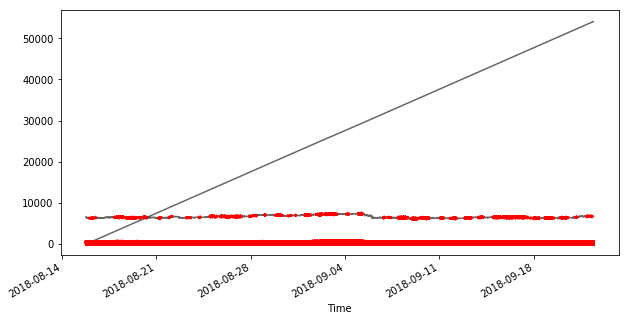

                     Unnamed: 0     bch      btc     eth    ltc      xpr
Time                                                                    
2018-08-15 18:45:00           0     NaN      NaN  297.56    NaN      NaN
2018-08-15 18:46:00           1     NaN  6547.42  297.81    NaN  0.29083
2018-08-15 18:47:00           2     NaN  6549.43  297.82    NaN  0.29084
2018-08-15 18:48:00           3     NaN  6547.86  298.37    NaN  0.29010
2018-08-15 18:49:00           4  529.41  6534.95  297.94  58.07  0.29084


In [66]:
# Interpolate linearly
interpolation_type = 'linear'
interpolate_and_plot(df, interpolation_type)

# Create a boolean mask for missing values
missing_values = df.isna()

# Interpolate the missing values
df = df.interpolate('linear')
print(df.head())

In continuation of using Bitcoin and Litecoin from our correlation methods, lets visualize a scatterplot with color relating to time; encoding time as the color of each datapoint. Because Bitcoin and Litecoin were used previously, let's continue ML analysis on those specific coins. Also, the two have very different prices along our timespan so I expect reliable, yet interesting results. When not comparing coins, the Bitcoin data will be used as it is the most popular and expensive currency. 

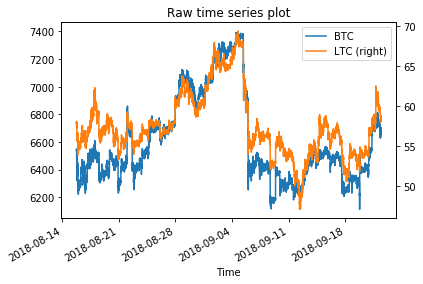

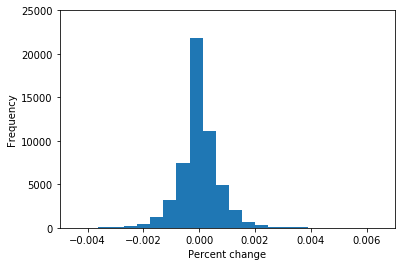

In [67]:
# Plot raw time series plot of bitcoin and litecoin
df['btc'].plot(label='BTC', legend=True)
df['ltc'].plot(label='LTC', legend=True, secondary_y=True)
plt.title('Raw time series plot')
plt.show()  # show the plot
plt.clf()  # clear the plot space

# Histogram of the daily price change percent 
df['btc'].pct_change().plot.hist(bins=80)
plt.axis([-.005,.007,0,25000])
plt.xlabel('Percent change')
plt.show()

Above we can see a nearly normal distribution. Although we've done correlation analysis already, let's use Pearson's correlation coefficient to detect any linear relationships. We'll check the correlations between current prices changes to see if previous price changes can predicture future price changes. Below, based on the outputted correlation matrix between 5 day percentage changes (current and future), we can discern a slighly negative correlation (-0.0225) to the change in the last 5 days, an example of mean reversion (stock price bounces around as opposed to following an upward trend).

                 5d_pct  5d_future_pct
5d_pct         1.000000      -0.022466
5d_future_pct -0.022466       1.000000


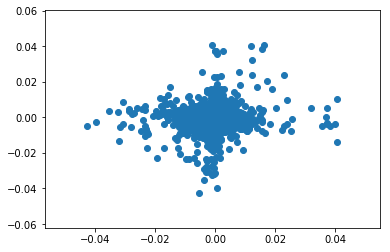

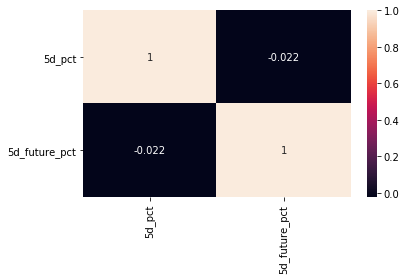

<Figure size 432x288 with 0 Axes>

In [77]:
# Create 5-day % changes of Adj_Close for the current day, and 5 days in the future
df['5d_future'] = df['btc'].shift(-5)
df['5d_future_pct'] = df['5d_future'].pct_change(5)
df['5d_pct'] = df['btc'].pct_change(5)

# Calculate the correlation matrix between the 5d close pecentage changes (current and future)
corr = df[['5d_pct', '5d_future_pct']].corr()
print(corr)

# Scatter the current 5-day percent change vs the future 5-day percent change
plt.scatter(df['5d_pct'], df['5d_future_pct'])
plt.show()

# Plot heatmap of correlation matrix
sns.heatmap(corr, annot=True)
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot
plt.clf() # clear the plot area

In [75]:
print(df.tail())

                     Unnamed: 0     bch      btc     eth    ltc      xpr  \
Time                                                                       
2018-09-22 10:03:00       54048  476.41  6691.28  237.19  58.72  0.58168   
2018-09-22 10:04:00       54049  477.02  6691.28  237.90  58.83  0.58249   
2018-09-22 10:05:00       54050  477.85  6698.05  237.90  58.76  0.58220   
2018-09-22 10:06:00       54051  477.99  6703.00  237.89  58.76  0.58201   
2018-09-22 10:07:00       54052  477.99  6701.00  237.52  58.76  0.58326   

                     5d_future  5d_future_pct    5d_pct  
Time                                                     
2018-09-22 10:03:00        NaN       0.001453  0.001071  
2018-09-22 10:04:00        NaN       0.001453  0.000718  
2018-09-22 10:05:00        NaN       0.000440  0.001377  
2018-09-22 10:06:00        NaN      -0.000298  0.002175  
2018-09-22 10:07:00        NaN       0.000000  0.001876  


In [92]:
from talib import RSI, SMA


feature_names = ['5d_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14, 30, 50, 200]:

    # Create the moving average indicator 
    df['ma' + str(n)] = talib.SMA(df['btc'].values,
                              timeperiod=n) / df['btc']
    # Create the RSI indicator
    lng_df['rsi' + str(n)] = talib.RSI(df['btc'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]
    
print(feature_names)

ModuleNotFoundError: No module named 'talib'

In [86]:
# Drop all na values
df = df.dropna()

# Create features and targets
# use feature_names for features; '5d_close_future_pct' for targets
features = df['5d_future']
targets = df['5d_future_pct']

# Create DataFrame from target column and feature columns
feature_and_target_cols = ['5d_future_pct'] + ['5d_future'] + ['5d_pct']
feat_targ_df = lng_df[feature_and_target_cols]

# Calculate correlation matrix
corr = feat_targ_df.corr()
print(corr)

               5d_future_pct  5d_future    5d_pct
5d_future_pct       1.000000   0.018261 -0.022482
5d_future           0.018261   1.000000  0.017406
5d_pct             -0.022482   0.017406  1.000000


In [87]:
# Import the statsmodels.api library with the alias sm
import statsmodels.api as sm

# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * features.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(54042, 2) (45935, 2) (8107, 2)


In [88]:
# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

                            OLS Regression Results                            
Dep. Variable:          5d_future_pct   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     14.77
Date:                Sun, 01 Dec 2019   Prob (F-statistic):           0.000122
Time:                        19:29:47   Log-Likelihood:             2.2564e+05
No. Observations:               45935   AIC:                        -4.513e+05
Df Residuals:                   45933   BIC:                        -4.513e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.000     -3.834      0.0

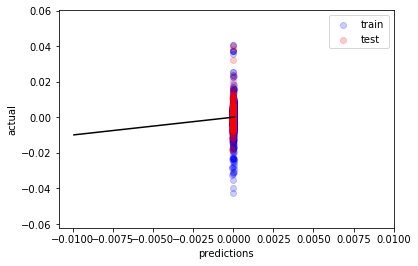

In [89]:
# Scatter the predictions vs the targets with 80% transparency
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()# show the legend
plt.show()

In [ ]:
df.plot.scatter('btc', 'ltc', c=df.index, 
                    cmap=plt.cm.viridis, colorbar=False)
plt.show()

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Use stock symbols to extract training data
X = df[['bch', 'eth', 'ltc', 'xpr']]
y = df[['btc']]

# Fit and score the model with cross-validation
scores = cross_val_score(Ridge(), X, y, cv=3)
print(scores)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Split our data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=.8, shuffle=False, random_state=1)

# Fit our model and generate predictions
model = Ridge()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
score = r2_score(y_test, predictions)
print(score)

# Visualize our predictions along with the "true" values, and print the score
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y_test, color='k', lw=3)
ax.plot(predictions, color='r', lw=2)
plt.show()